In [1]:
import os, math
import _pickle as pickle
from datetime import datetime, timedelta

import numpy as np
import pandas as pd
from sklearn import preprocessing

In [2]:
# import tensorflow.keras.backend as K
import numpy as np
def rho_risk2(y_true, y_pred, rho):
    #
    # This function calculates the quantile risk between the true and the predicted outputs
    #
    num1 = (y_true-y_pred)*rho*(y_true>=y_pred)
    num2 = (y_pred-y_true)*(1-rho)*(y_true<y_pred)
    den  = np.sum(np.abs(y_true), axis=None)
    
    return 2*(np.sum(num1, axis=None)+np.sum(num2, axis=None))/den

def nrmse(y_true, y_pred):
    #
    # The formula is:
    #           K.sqrt(K.mean(K.square(y_pred - y_true)))    
    #    NRMSE = -----------------------------------------------
    #           K.mean(K.sum(y_true))       
    #
    num = K.sqrt(K.mean(K.square(y_true - y_pred), axis=None))
    den = K.mean(K.abs(y_true), axis=None)
    
    return num / den

def rho_risk(y_true, y_pred, rho):
    #
    # This function calculates the quantile risk between the true and the predicted outputs
    #
    num = -np.sum(2*(y_pred-y_true)*(rho*(y_pred<=y_true)-(1-rho)*(y_pred>y_true)), axis=None)
    den  = np.sum(np.abs(y_true), axis=None)
    
    return num/den

def smape(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred))
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0
    return 200 * np.mean(diff)

def ND(y_pred, y_true):
    demoninator = np.sum(np.abs(y_true))
    diff = np.sum(np.abs(y_true - y_pred))
    return 1.0*diff/demoninator

def rmsle(y_pred, y_true) :
    assert len(y_true) == len(y_pred)
    return np.sqrt(np.mean((np.log(1+y_pred) - np.log(1+y_true))**2))

def NRMSE(y_pred, y_true):
    assert len(y_pred) == len(y_true)
    denominator = np.mean(np.abs(y_true))
    diff = np.sqrt(np.mean(((y_pred-y_true)**2)))
    return diff/denominator

def rho_risk22(y_pred,y_true,rho):
    assert len(y_pred) == len(y_true)
    diff1 = (y_true-y_pred)*rho*(y_true>=y_pred)
    diff2 = (y_pred-y_true)*(1-rho)*(y_true<y_pred)
    denominator = np.sum(y_true)
    return 2*(np.sum(diff1)+np.sum(diff2))/denominator

In [4]:
import os 
import pandas as pd
import numpy as np

series = {'load':[0,59],
          'price':[59,90],
          'wind':[90, 147],
          'solar':[147, 183]}

datasets = ['power_hop', 'elect_hop']
df_test_metric = pd.DataFrame(columns=['ND', 'NRMSE', 'QL10', 'QL50', 'QL90'])
horizons = [36]

for dataset in datasets:
    for horizon in horizons:
        folder_path = dataset + '_%d' % horizon
        directory_path = os.path.join('./save', dataset)
        Y_true = np.load(directory_path + '_' + str(horizon) + '_true.npy')
        Y_hat_1 = np.load(directory_path + '_' + str(horizon) + '_q_10.npy')
        Y_hat_5 = np.load(directory_path + '_' + str(horizon) + '_q_50.npy')
        Y_hat_9 = np.load(directory_path + '_' + str(horizon) + '_q_90.npy')
        
        if dataset == 'elect_hop':
            k = 321
            Y_true = np.delete(np.fliplr(Y_true.reshape(k, int(Y_true.shape[0]/k)*horizon))[:,-5256:], 182, 0)
            Y_hat_1 = np.delete(np.fliplr(Y_hat_1.reshape(k, int(Y_hat_1.shape[0]/k)*horizon))[:,-5256:], 182, 0)
            Y_hat_5 = np.delete(np.fliplr(Y_hat_5.reshape(k, int(Y_hat_5.shape[0]/k)*horizon))[:,-5256:], 182, 0)
            Y_hat_9 = np.delete(np.fliplr(Y_hat_9.reshape(k, int(Y_hat_9.shape[0]/k)*horizon))[:,-5256:], 182, 0)
        else:
            k = 183
            Y_true = np.fliplr(Y_true.reshape(k, int(Y_true.shape[0]/k)*horizon))[:,-3816:]
            Y_hat_1 = np.fliplr(Y_hat_1.reshape(k, int(Y_hat_1.shape[0]/k)*horizon))[:,-3816:]
            Y_hat_5 = np.fliplr(Y_hat_5.reshape(k, int(Y_hat_5.shape[0]/k)*horizon))[:,-3816:]
            Y_hat_9 = np.fliplr(Y_hat_9.reshape(k, int(Y_hat_9.shape[0]/k)*horizon))[:,-3816:]
            
        _nd = ND(Y_hat_5, Y_true)#.mean()
        _nrmse = NRMSE(Y_hat_5, Y_true)#.mean()
        _pho_risk1 = rho_risk2(Y_true, Y_hat_1, 0.1)#.mean()
        _pho_risk5 = rho_risk2(Y_true, Y_hat_5, 0.5)#.mean()
        _pho_risk9 = rho_risk2(Y_true, Y_hat_9, 0.9)#.mean()
        print('Loss metric %s %d ND: %f, NRMSE: %f, Ql10: %f, Ql50: %f, Ql90: %f' % (dataset,
                                                                                     horizon,
                                                                                     _nd,
                                                                                     _nrmse,
                                                                                     _pho_risk1,
                                                                                     _pho_risk5,
                                                                                     _pho_risk9))
        df_test_metric.loc[folder_path] = [_nd, 
                                           _nrmse,
                                           _pho_risk1,
                                           _pho_risk5,
                                           _pho_risk9]
        if dataset == 'power_hop':
            for key in series:
                Y_true_ = Y_true[series[key][0]:series[key][1],:]
                Y_hat_1_ = Y_hat_1[series[key][0]:series[key][1],:]
                Y_hat_5_ = Y_hat_5[series[key][0]:series[key][1],:]
                Y_hat_9_ = Y_hat_9[series[key][0]:series[key][1],:]
                
                _nd = ND(Y_hat_5_, Y_true_)#.mean()
                _nrmse = NRMSE(Y_hat_5_, Y_true_)#.mean()
                _pho_risk1 = rho_risk2(Y_true_, Y_hat_1_, 0.1)#.mean()
                _pho_risk5 = rho_risk2(Y_true_, Y_hat_5_, 0.5)#.mean()
                _pho_risk9 = rho_risk2(Y_true_, Y_hat_9_, 0.9)#.mean()
                print('Loss metric %s_%s  %d ND: %f, NRMSE: %f, Ql10: %f, Ql50: %f, Ql90: %f' % (dataset,
                                                                                                 key,
                                                                                                 horizon,
                                                                                                 _nd,
                                                                                                 _nrmse,
                                                                                                 _pho_risk1,
                                                                                                 _pho_risk5,
                                                                                                 _pho_risk9))
                df_test_metric.loc[folder_path + '_' + key] = [_nd, 
                                                               _nrmse,
                                                               _pho_risk1,
                                                               _pho_risk5,
                                                               _pho_risk9]
#df_test_metric.reset_index().rename(columns={'index':'Scenario'}).to_csv('./save/test_metrics_hop.csv', index=False)

Loss metric power_hop 36 ND: 0.119297, NRMSE: 0.307147, Ql10: 0.070802, Ql50: 0.119297, Ql90: 0.085711
Loss metric power_hop_load  36 ND: 0.059615, NRMSE: 0.115414, Ql10: 0.050342, Ql50: 0.059615, Ql90: 0.054217
Loss metric power_hop_price  36 ND: 0.353813, NRMSE: 0.472667, Ql10: 0.201588, Ql50: 0.353813, Ql90: 0.160917
Loss metric power_hop_wind  36 ND: 0.471491, NRMSE: 1.097971, Ql10: 0.191450, Ql50: 0.471491, Ql90: 0.281561
Loss metric power_hop_solar  36 ND: 0.288505, NRMSE: 0.887129, Ql10: 0.126247, Ql50: 0.288505, Ql90: 0.139233
Loss metric elect_hop 36 ND: 0.107723, NRMSE: 0.829059, Ql10: 0.049947, Ql50: 0.107723, Ql90: 0.055560


In [3]:
import os 
import pandas as pd
import numpy as np

series = {'load':[0,59],
          'price':[59,90],
          'wind':[90, 147],
          'solar':[147, 183]}

datasets = ['power_hop', 'elect_hop']
df_test_metric = pd.DataFrame(columns=['ND', 'NRMSE', 'QL10', 'QL50', 'QL90'])
horizons = [36]

for dataset in datasets:
    for horizon in horizons:
        prefix = '_3'
        folder_path = dataset + '_%d' % horizon
        directory_path = os.path.join('./save', dataset)
        Y_true = np.load(directory_path + '_' + str(horizon) + prefix+ '_true.npy')
        Y_hat_1 = np.load(directory_path + '_' + str(horizon)+ prefix + '_q_10.npy')
        Y_hat_5 = np.load(directory_path + '_' + str(horizon)+ prefix + '_q_50.npy')
        Y_hat_9 = np.load(directory_path + '_' + str(horizon)+ prefix + '_q_90.npy')
        
        if dataset == 'elect_hop':
            k = 321
            Y_true = np.fliplr(Y_true.reshape(k, int(Y_true.shape[0]/k)*horizon))[:,-5256:]#, 182, 0)
            Y_hat_1 = np.fliplr(Y_hat_1.reshape(k, int(Y_hat_1.shape[0]/k)*horizon))[:,-5256:]#, 182, 0)
            Y_hat_5 = np.fliplr(Y_hat_5.reshape(k, int(Y_hat_5.shape[0]/k)*horizon))[:,-5256:]#, 182, 0)
            Y_hat_9 = np.fliplr(Y_hat_9.reshape(k, int(Y_hat_9.shape[0]/k)*horizon))[:,-5256:]#, 182, 0)
        else:
            k = 183
            Y_true = np.fliplr(Y_true.reshape(k, int(Y_true.shape[0]/k)*horizon))[:,-3816:]
            Y_hat_1 = np.fliplr(Y_hat_1.reshape(k, int(Y_hat_1.shape[0]/k)*horizon))[:,-3816:]
            Y_hat_5 = np.fliplr(Y_hat_5.reshape(k, int(Y_hat_5.shape[0]/k)*horizon))[:,-3816:]
            Y_hat_9 = np.fliplr(Y_hat_9.reshape(k, int(Y_hat_9.shape[0]/k)*horizon))[:,-3816:]
            
        _nd = ND(Y_hat_5, Y_true)#.mean()
        _nrmse = NRMSE(Y_hat_5, Y_true)#.mean()
        _pho_risk1 = rho_risk2(Y_true, Y_hat_1, 0.1)#.mean()
        _pho_risk5 = rho_risk2(Y_true, Y_hat_5, 0.5)#.mean()
        _pho_risk9 = rho_risk2(Y_true, Y_hat_9, 0.9)#.mean()
        print('Loss metric %s %d ND: %f, NRMSE: %f, Ql10: %f, Ql50: %f, Ql90: %f' % (dataset,
                                                                                     horizon,
                                                                                     _nd,
                                                                                     _nrmse,
                                                                                     _pho_risk1,
                                                                                     _pho_risk5,
                                                                                     _pho_risk9))
        df_test_metric.loc[folder_path] = [_nd, 
                                           _nrmse,
                                           _pho_risk1,
                                           _pho_risk5,
                                           _pho_risk9]
        if dataset == 'power_hop':
            for key in series:
                Y_true_ = Y_true[series[key][0]:series[key][1],:]
                Y_hat_1_ = Y_hat_1[series[key][0]:series[key][1],:]
                Y_hat_5_ = Y_hat_5[series[key][0]:series[key][1],:]
                Y_hat_9_ = Y_hat_9[series[key][0]:series[key][1],:]
                
                _nd = ND(Y_hat_5_, Y_true_)#.mean()
                _nrmse = NRMSE(Y_hat_5_, Y_true_)#.mean()
                _pho_risk1 = rho_risk2(Y_true_, Y_hat_1_, 0.1)#.mean()
                _pho_risk5 = rho_risk2(Y_true_, Y_hat_5_, 0.5)#.mean()
                _pho_risk9 = rho_risk2(Y_true_, Y_hat_9_, 0.9)#.mean()
                print('Loss metric %s_%s  %d ND: %f, NRMSE: %f, Ql10: %f, Ql50: %f, Ql90: %f' % (dataset,
                                                                                                 key,
                                                                                                 horizon,
                                                                                                 _nd,
                                                                                                 _nrmse,
                                                                                                 _pho_risk1,
                                                                                                 _pho_risk5,
                                                                                                 _pho_risk9))
                df_test_metric.loc[folder_path + '_' + key] = [_nd, 
                                                               _nrmse,
                                                               _pho_risk1,
                                                               _pho_risk5,
                                                               _pho_risk9]
df_test_metric.reset_index().rename(columns={'index':'Scenario'}).to_csv('./save/test_metrics_hop_3.csv', index=False)

Loss metric power_hop 36 ND: 0.110057, NRMSE: 0.308928, Ql10: 0.057269, Ql50: 0.110057, Ql90: 0.069649
Loss metric power_hop_load  36 ND: 0.045006, NRMSE: 0.093102, Ql10: 0.032248, Ql50: 0.045006, Ql90: 0.036810
Loss metric power_hop_price  36 ND: 0.499657, NRMSE: 0.605226, Ql10: 0.201737, Ql50: 0.499657, Ql90: 0.156494
Loss metric power_hop_wind  36 ND: 0.489644, NRMSE: 1.186948, Ql10: 0.208366, Ql50: 0.489644, Ql90: 0.268035
Loss metric power_hop_solar  36 ND: 0.303275, NRMSE: 0.986457, Ql10: 0.112253, Ql50: 0.303275, Ql90: 0.147456
Loss metric elect_hop 36 ND: 0.113785, NRMSE: 0.820109, Ql10: 0.050690, Ql50: 0.113785, Ql90: 0.063361


In [24]:
df_test_metric

,ND,NRMSE,QL10,QL50,QL90
power_hop_36,0.110057,0.308928,0.057269,0.110057,0.069649
power_hop_36_load,0.045006,0.093102,0.032248,0.045006,0.036810
power_hop_36_price,0.499657,0.605226,0.201737,0.499657,0.156494
power_hop_36_wind,0.489644,1.186948,0.208366,0.489644,0.268035
power_hop_36_solar,0.303275,0.986457,0.112253,0.303275,0.147456
elect_hop_36,0.113759,0.818831,0.050681,0.113759,0.063349


In [7]:
df_test_metric

,ND,NRMSE,QL10,QL50,QL90
power_hop_36,0.119297,0.307147,0.070802,0.119297,0.085711
power_hop_36_load,0.059615,0.115414,0.050342,0.059615,0.054217
power_hop_36_price,0.353813,0.472667,0.201588,0.353813,0.160917
power_hop_36_wind,0.471491,1.097971,0.191450,0.471491,0.281561
power_hop_36_solar,0.288505,0.887129,0.126247,0.288505,0.139233
elect_hop_36,0.107723,0.829059,0.049947,0.107723,0.055560


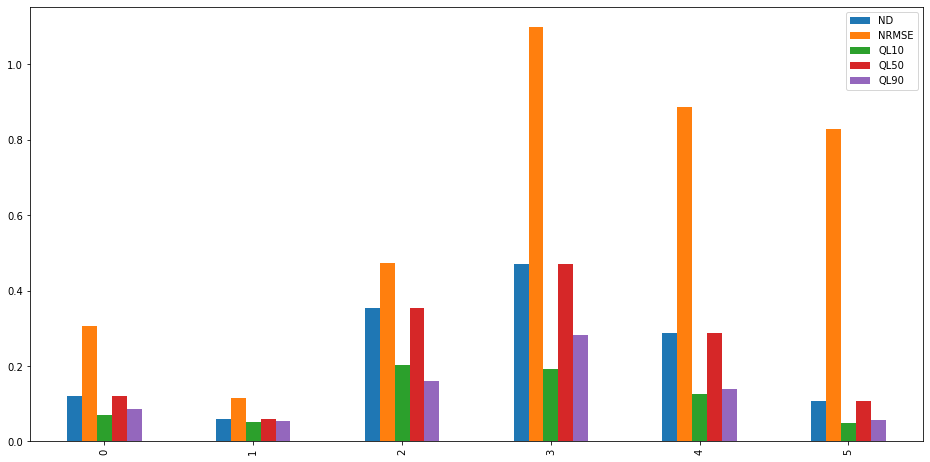

In [6]:
import matplotlib.pyplot as plt
pd.read_csv('./save/test_metrics_hop.csv').plot(kind='bar', figsize=(16, 8))
plt.savefig('./save/test_metrics_hop.pdf', format='pdf')

In [3]:
import os 
import pandas as pd
import numpy as np

series = {'load':[0,59],
          'price':[59,90],
          'wind':[90, 147],
          'solar':[147, 183]}

datasets = ['power']
df_test_metric = pd.DataFrame(columns=['ND', 'NRMSE', 'QL10', 'QL50', 'QL90'])
horizons = [3]

for dataset in datasets:
    for horizon in horizons:
        prefix = '_3'
        folder_path = dataset + '_%d%s' % (horizon, prefix)
        directory_path = os.path.join('./save', dataset)
        Y_true = np.load(directory_path + '_' + str(horizon) + prefix +  '_true.npy')
        Y_hat_1 = np.load(directory_path + '_' + str(horizon) + prefix + '_q_10.npy')
        Y_hat_5 = np.load(directory_path + '_' + str(horizon) + prefix + '_q_50.npy')
        Y_hat_9 = np.load(directory_path + '_' + str(horizon) + prefix + '_q_90.npy')
        
        if dataset == 'elect':
            k = 321
            Y_true = np.delete(np.fliplr(Y_true.reshape(k, int(Y_true.shape[0]/k)*horizon))[:,-5256:], 182, 0)
            Y_hat_1 = np.delete(np.fliplr(Y_hat_1.reshape(k, int(Y_hat_1.shape[0]/k)*horizon))[:,-5256:], 182, 0)
            Y_hat_5 = np.delete(np.fliplr(Y_hat_5.reshape(k, int(Y_hat_5.shape[0]/k)*horizon))[:,-5256:], 182, 0)
            Y_hat_9 = np.delete(np.fliplr(Y_hat_9.reshape(k, int(Y_hat_9.shape[0]/k)*horizon))[:,-5256:], 182, 0)
        else:
            k = 183
            Y_true = np.fliplr(Y_true.reshape(k, int(Y_true.shape[0]/k)*horizon))[:,-3816:]
            Y_hat_1 = np.fliplr(Y_hat_1.reshape(k, int(Y_hat_1.shape[0]/k)*horizon))[:,-3816:]
            Y_hat_5 = np.fliplr(Y_hat_5.reshape(k, int(Y_hat_5.shape[0]/k)*horizon))[:,-3816:]
            Y_hat_9 = np.fliplr(Y_hat_9.reshape(k, int(Y_hat_9.shape[0]/k)*horizon))[:,-3816:]
            
        _nd = ND(Y_hat_5, Y_true)#.mean()
        _nrmse = NRMSE(Y_hat_5, Y_true)#.mean()
        _pho_risk1 = rho_risk2(Y_true, Y_hat_1, 0.1)#.mean()
        _pho_risk5 = rho_risk2(Y_true, Y_hat_5, 0.5)#.mean()
        _pho_risk9 = rho_risk2(Y_true, Y_hat_9, 0.9)#.mean()
        print('Loss metric %s %d ND: %f, NRMSE: %f, Ql10: %f, Ql50: %f, Ql90: %f' % (dataset,
                                                                                     horizon,
                                                                                     _nd,
                                                                                     _nrmse,
                                                                                     _pho_risk1,
                                                                                     _pho_risk5,
                                                                                     _pho_risk9))
        df_test_metric.loc[folder_path] = [_nd, 
                                           _nrmse,
                                           _pho_risk1,
                                           _pho_risk5,
                                           _pho_risk9]
        if dataset == 'power':
            for key in series:
                Y_true_ = Y_true[series[key][0]:series[key][1],:]
                Y_hat_1_ = Y_hat_1[series[key][0]:series[key][1],:]
                Y_hat_5_ = Y_hat_5[series[key][0]:series[key][1],:]
                Y_hat_9_ = Y_hat_9[series[key][0]:series[key][1],:]
                
                _nd = ND(Y_hat_5_, Y_true_)#.mean()
                _nrmse = NRMSE(Y_hat_5_, Y_true_)#.mean()
                _pho_risk1 = rho_risk2(Y_true_, Y_hat_1_, 0.1)#.mean()
                _pho_risk5 = rho_risk2(Y_true_, Y_hat_5_, 0.5)#.mean()
                _pho_risk9 = rho_risk2(Y_true_, Y_hat_9_, 0.9)#.mean()
                print('Loss metric %s_%s  %d ND: %f, NRMSE: %f, Ql10: %f, Ql50: %f, Ql90: %f' % (dataset,
                                                                                                 key,
                                                                                                 horizon,
                                                                                                 _nd,
                                                                                                 _nrmse,
                                                                                                 _pho_risk1,
                                                                                                 _pho_risk5,
                                                                                                 _pho_risk9))
                df_test_metric.loc[folder_path + '_' + key] = [_nd, 
                                                               _nrmse,
                                                               _pho_risk1,
                                                               _pho_risk5,
                                                               _pho_risk9]
df_test_metric

Loss metric power 3 ND: 0.039250, NRMSE: 0.098358, Ql10: 0.024673, Ql50: 0.039250, Ql90: 0.030353
Loss metric power_load  3 ND: 0.025044, NRMSE: 0.051171, Ql10: 0.019117, Ql50: 0.025044, Ql90: 0.023574
Loss metric power_price  3 ND: 0.295248, NRMSE: 0.430596, Ql10: 0.199438, Ql50: 0.295248, Ql90: 0.207921
Loss metric power_wind  3 ND: 0.107962, NRMSE: 0.248384, Ql10: 0.050614, Ql50: 0.107962, Ql90: 0.061567
Loss metric power_solar  3 ND: 0.126267, NRMSE: 0.390242, Ql10: 0.057983, Ql50: 0.126267, Ql90: 0.074752


,ND,NRMSE,QL10,QL50,QL90
power_3_3,0.039250,0.098358,0.024673,0.039250,0.030353
power_3_3_load,0.025044,0.051171,0.019117,0.025044,0.023574
power_3_3_price,0.295248,0.430596,0.199438,0.295248,0.207921
power_3_3_wind,0.107962,0.248384,0.050614,0.107962,0.061567
power_3_3_solar,0.126267,0.390242,0.057983,0.126267,0.074752


In [43]:
df_test_metric

,ND,NRMSE,QL10,QL50,QL90
power_3,0.081162,0.175284,0.062159,0.081162,0.074752
power_3_load,0.055854,0.101662,0.057087,0.055854,0.064965
power_3_price,0.467341,0.640805,0.200617,0.467341,0.358846
power_3_wind,0.203656,0.344502,0.085530,0.203656,0.118576
power_3_solar,0.239899,0.623421,0.094981,0.239899,0.142036
power_6,0.073528,0.171118,0.042531,0.073528,0.049279
power_6_load,0.045158,0.084828,0.033423,0.045158,0.035566
power_6_price,0.395722,0.517329,0.201761,0.395722,0.209528
power_6_wind,0.215990,0.461557,0.086991,0.215990,0.118465
power_6_solar,0.238033,0.715387,0.097035,0.238033,0.127270


In [6]:
import os 
import pandas as pd
import numpy as np

series = {'load':[0,59],
          'price':[59,90],
          'wind':[90, 147],
          'solar':[147, 183]}

datasets = ['power']
df_test_metric = pd.DataFrame(columns=['ND', 'NRMSE', 'QL10', 'QL50', 'QL90'])
horizons = [3, 6, 12, 24]

for dataset in datasets:
    for horizon in horizons:
        prefix = '_3'
        folder_path = dataset + '_%d%s' % (horizon, prefix)
        directory_path = os.path.join('./save', dataset)
        Y_true = np.load(directory_path + '_' + str(horizon) + prefix +  '_true.npy')
        Y_hat_1 = np.load(directory_path + '_' + str(horizon) + prefix + '_q_10.npy')
        Y_hat_5 = np.load(directory_path + '_' + str(horizon) + prefix + '_q_50.npy')
        Y_hat_9 = np.load(directory_path + '_' + str(horizon) + prefix + '_q_90.npy')
        
        if dataset == 'elect':
            k = 321
            Y_true = np.delete(np.fliplr(Y_true.reshape(k, int(Y_true.shape[0]/k)*horizon))[:,-5256:], 182, 0)
            Y_hat_1 = np.delete(np.fliplr(Y_hat_1.reshape(k, int(Y_hat_1.shape[0]/k)*horizon))[:,-5256:], 182, 0)
            Y_hat_5 = np.delete(np.fliplr(Y_hat_5.reshape(k, int(Y_hat_5.shape[0]/k)*horizon))[:,-5256:], 182, 0)
            Y_hat_9 = np.delete(np.fliplr(Y_hat_9.reshape(k, int(Y_hat_9.shape[0]/k)*horizon))[:,-5256:], 182, 0)
        else:
            k = 183
            Y_true = np.fliplr(Y_true.reshape(k, int(Y_true.shape[0]/k)*horizon))[:,-3816:]
            Y_hat_1 = np.fliplr(Y_hat_1.reshape(k, int(Y_hat_1.shape[0]/k)*horizon))[:,-3816:]
            Y_hat_5 = np.fliplr(Y_hat_5.reshape(k, int(Y_hat_5.shape[0]/k)*horizon))[:,-3816:]
            Y_hat_9 = np.fliplr(Y_hat_9.reshape(k, int(Y_hat_9.shape[0]/k)*horizon))[:,-3816:]
            
        _nd = ND(Y_hat_5, Y_true)#.mean()
        _nrmse = NRMSE(Y_hat_5, Y_true)#.mean()
        _pho_risk1 = rho_risk2(Y_true, Y_hat_1, 0.1)#.mean()
        _pho_risk5 = rho_risk2(Y_true, Y_hat_5, 0.5)#.mean()
        _pho_risk9 = rho_risk2(Y_true, Y_hat_9, 0.9)#.mean()
        print('Loss metric %s %d ND: %f, NRMSE: %f, Ql10: %f, Ql50: %f, Ql90: %f' % (dataset,
                                                                                     horizon,
                                                                                     _nd,
                                                                                     _nrmse,
                                                                                     _pho_risk1,
                                                                                     _pho_risk5,
                                                                                     _pho_risk9))
        df_test_metric.loc[folder_path] = [_nd, 
                                           _nrmse,
                                           _pho_risk1,
                                           _pho_risk5,
                                           _pho_risk9]
        if dataset == 'power':
            for key in series:
                Y_true_ = Y_true[series[key][0]:series[key][1],:]
                Y_hat_1_ = Y_hat_1[series[key][0]:series[key][1],:]
                Y_hat_5_ = Y_hat_5[series[key][0]:series[key][1],:]
                Y_hat_9_ = Y_hat_9[series[key][0]:series[key][1],:]
                
                _nd = ND(Y_hat_5_, Y_true_)#.mean()
                _nrmse = NRMSE(Y_hat_5_, Y_true_)#.mean()
                _pho_risk1 = rho_risk2(Y_true_, Y_hat_1_, 0.1)#.mean()
                _pho_risk5 = rho_risk2(Y_true_, Y_hat_5_, 0.5)#.mean()
                _pho_risk9 = rho_risk2(Y_true_, Y_hat_9_, 0.9)#.mean()
                print('Loss metric %s_%s  %d ND: %f, NRMSE: %f, Ql10: %f, Ql50: %f, Ql90: %f' % (dataset,
                                                                                                 key,
                                                                                                 horizon,
                                                                                                 _nd,
                                                                                                 _nrmse,
                                                                                                 _pho_risk1,
                                                                                                 _pho_risk5,
                                                                                                 _pho_risk9))
                df_test_metric.loc[folder_path + '_' + key] = [_nd, 
                                                               _nrmse,
                                                               _pho_risk1,
                                                               _pho_risk5,
                                                               _pho_risk9]
df_test_metric

Loss metric power 3 ND: 0.051651, NRMSE: 0.126459, Ql10: 0.200004, Ql50: 0.051651, Ql90: 0.041436
Loss metric power_load  3 ND: 0.034483, NRMSE: 0.068374, Ql10: 0.200000, Ql50: 0.034483, Ql90: 0.034564
Loss metric power_price  3 ND: 0.447486, NRMSE: 0.545776, Ql10: 0.201761, Ql50: 0.447486, Ql90: 0.146847
Loss metric power_wind  3 ND: 0.132783, NRMSE: 0.303485, Ql10: 0.200000, Ql50: 0.132783, Ql90: 0.073391
Loss metric power_solar  3 ND: 0.159169, NRMSE: 0.451212, Ql10: 0.200032, Ql50: 0.159169, Ql90: 0.089545
Loss metric power 6 ND: 0.065161, NRMSE: 0.156762, Ql10: 0.200004, Ql50: 0.065161, Ql90: 0.034518
Loss metric power_load  6 ND: 0.037010, NRMSE: 0.073392, Ql10: 0.200000, Ql50: 0.037010, Ql90: 0.017808
Loss metric power_price  6 ND: 0.486335, NRMSE: 0.567486, Ql10: 0.201761, Ql50: 0.486335, Ql90: 0.150315
Loss metric power_wind  6 ND: 0.203727, NRMSE: 0.443285, Ql10: 0.200000, Ql50: 0.203727, Ql90: 0.122861
Loss metric power_solar  6 ND: 0.233300, NRMSE: 0.726800, Ql10: 0.200032,

,ND,NRMSE,QL10,QL50,QL90
power_3_3,0.051651,0.126459,0.200004,0.051651,0.041436
power_3_3_load,0.034483,0.068374,0.200000,0.034483,0.034564
power_3_3_price,0.447486,0.545776,0.201761,0.447486,0.146847
power_3_3_wind,0.132783,0.303485,0.200000,0.132783,0.073391
power_3_3_solar,0.159169,0.451212,0.200032,0.159169,0.089545
power_6_3,0.065161,0.156762,0.200004,0.065161,0.034518
power_6_3_load,0.037010,0.073392,0.200000,0.037010,0.017808
power_6_3_price,0.486335,0.567486,0.201761,0.486335,0.150315
power_6_3_wind,0.203727,0.443285,0.200000,0.203727,0.122861
power_6_3_solar,0.233300,0.726800,0.200032,0.233300,0.118576


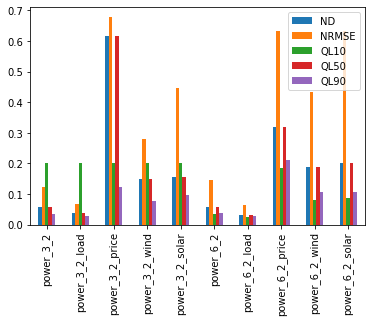

In [11]:
df_test_metric.plot(kind='bar')

In [4]:
import os 
import pandas as pd
import numpy as np

series = {'load':[0,59],
          'price':[59,90],
          'wind':[90, 147],
          'solar':[147, 183]}

datasets = ['power', 'elect']
df_test_metric = pd.DataFrame(columns=['ND', 'NRMSE', 'QL10', 'QL50', 'QL90'])
horizons = [3, 6, 12, 24, 36]

for dataset in datasets:
    for horizon in horizons:
        if dataset=='power' and (horizon in [3, 6, 12, 24]):
            prefix = '_3'
        elif dataset=='elect' and horizon in [6]:
            prefix = '_2'
        else:
            prefix=''
            
        folder_path = dataset + '_%d%s' % (horizon, prefix)
        directory_path = os.path.join('./save', dataset)
        Y_true = np.load(directory_path + '_' + str(horizon) + prefix +  '_true.npy')
        Y_hat_1 = np.load(directory_path + '_' + str(horizon) + prefix + '_q_10.npy')
        Y_hat_5 = np.load(directory_path + '_' + str(horizon) + prefix + '_q_50.npy')
        Y_hat_9 = np.load(directory_path + '_' + str(horizon) + prefix + '_q_90.npy')
        
        if dataset == 'elect':
            k = 321
            Y_true = np.fliplr(Y_true.reshape(k, int(Y_true.shape[0]/k)*horizon))[:,-5256:]#, 182, 0)
            Y_hat_1 = np.fliplr(Y_hat_1.reshape(k, int(Y_hat_1.shape[0]/k)*horizon))[:,-5256:]#, 182, 0)
            Y_hat_5 = np.fliplr(Y_hat_5.reshape(k, int(Y_hat_5.shape[0]/k)*horizon))[:,-5256:]#, 182, 0)
            Y_hat_9 = np.fliplr(Y_hat_9.reshape(k, int(Y_hat_9.shape[0]/k)*horizon))[:,-5256:]#, 182, 0)
        else:
            k = 183
            Y_true = np.fliplr(Y_true.reshape(k, int(Y_true.shape[0]/k)*horizon))[:,-3816:]
            Y_hat_1 = np.fliplr(Y_hat_1.reshape(k, int(Y_hat_1.shape[0]/k)*horizon))[:,-3816:]
            Y_hat_5 = np.fliplr(Y_hat_5.reshape(k, int(Y_hat_5.shape[0]/k)*horizon))[:,-3816:]
            Y_hat_9 = np.fliplr(Y_hat_9.reshape(k, int(Y_hat_9.shape[0]/k)*horizon))[:,-3816:]
            
        _nd = ND(Y_hat_5, Y_true)#.mean()
        _nrmse = NRMSE(Y_hat_5, Y_true)#.mean()
        _pho_risk1 = rho_risk2(Y_true, Y_hat_1, 0.1)#.mean()
        _pho_risk5 = rho_risk2(Y_true, Y_hat_5, 0.5)#.mean()
        _pho_risk9 = rho_risk2(Y_true, Y_hat_9, 0.9)#.mean()
        print('Loss metric %s %d ND: %f, NRMSE: %f, Ql10: %f, Ql50: %f, Ql90: %f' % (dataset,
                                                                                     horizon,
                                                                                     _nd,
                                                                                     _nrmse,
                                                                                     _pho_risk1,
                                                                                     _pho_risk5,
                                                                                     _pho_risk9))
        df_test_metric.loc[folder_path] = [_nd, 
                                           _nrmse,
                                           _pho_risk1,
                                           _pho_risk5,
                                           _pho_risk9]
        if dataset == 'power':
            for key in series:
                Y_true_ = Y_true[series[key][0]:series[key][1],:]
                Y_hat_1_ = Y_hat_1[series[key][0]:series[key][1],:]
                Y_hat_5_ = Y_hat_5[series[key][0]:series[key][1],:]
                Y_hat_9_ = Y_hat_9[series[key][0]:series[key][1],:]
                
                _nd = ND(Y_hat_5_, Y_true_)#.mean()
                _nrmse = NRMSE(Y_hat_5_, Y_true_)#.mean()
                _pho_risk1 = rho_risk2(Y_true_, Y_hat_1_, 0.1)#.mean()
                _pho_risk5 = rho_risk2(Y_true_, Y_hat_5_, 0.5)#.mean()
                _pho_risk9 = rho_risk2(Y_true_, Y_hat_9_, 0.9)#.mean()
                print('Loss metric %s_%s  %d ND: %f, NRMSE: %f, Ql10: %f, Ql50: %f, Ql90: %f' % (dataset,
                                                                                                 key,
                                                                                                 horizon,
                                                                                                 _nd,
                                                                                                 _nrmse,
                                                                                                 _pho_risk1,
                                                                                                 _pho_risk5,
                                                                                                 _pho_risk9))
                df_test_metric.loc[folder_path + '_' + key] = [_nd, 
                                                               _nrmse,
                                                               _pho_risk1,
                                                               _pho_risk5,
                                                               _pho_risk9]
df_test_metric.reset_index().rename(columns={'index':'Scenario'}).to_csv('./save/test_metrics.csv', index=False)

Loss metric power 3 ND: 0.039250, NRMSE: 0.098358, Ql10: 0.024673, Ql50: 0.039250, Ql90: 0.030353
Loss metric power_load  3 ND: 0.025044, NRMSE: 0.051171, Ql10: 0.019117, Ql50: 0.025044, Ql90: 0.023574
Loss metric power_price  3 ND: 0.295248, NRMSE: 0.430596, Ql10: 0.199438, Ql50: 0.295248, Ql90: 0.207921
Loss metric power_wind  3 ND: 0.107962, NRMSE: 0.248384, Ql10: 0.050614, Ql50: 0.107962, Ql90: 0.061567
Loss metric power_solar  3 ND: 0.126267, NRMSE: 0.390242, Ql10: 0.057983, Ql50: 0.126267, Ql90: 0.074752
Loss metric power 6 ND: 0.053907, NRMSE: 0.133395, Ql10: 0.034182, Ql50: 0.053907, Ql90: 0.040059
Loss metric power_load  6 ND: 0.028906, NRMSE: 0.057406, Ql10: 0.025527, Ql50: 0.028906, Ql90: 0.027646
Loss metric power_price  6 ND: 0.445960, NRMSE: 0.532767, Ql10: 0.201744, Ql50: 0.445960, Ql90: 0.142910
Loss metric power_wind  6 ND: 0.181759, NRMSE: 0.416736, Ql10: 0.077455, Ql50: 0.181759, Ql90: 0.105924
Loss metric power_solar  6 ND: 0.183706, NRMSE: 0.577512, Ql10: 0.081084,

### Non-exogeneous 

In [5]:
import os 
import pandas as pd
import numpy as np

series = {'load':[0,59],
          'price':[59,90],
          'wind':[90, 147],
          'solar':[147, 183]}

datasets = ['power_nonex']
df_test_metric = pd.DataFrame(columns=['ND', 'NRMSE', 'QL10', 'QL50', 'QL90'])
horizons = [36]

for dataset in datasets:
    for horizon in horizons:
        prefix = ''
        folder_path = dataset + '_%d' % horizon
        directory_path = os.path.join('./save', dataset)
        print(directory_path + '_' + str(horizon) + prefix+ '_true.npy')
        Y_true = np.load(directory_path + '_' + str(horizon) + prefix+ '_true.npy')
        Y_hat_1 = np.load(directory_path + '_' + str(horizon)+ prefix + '_q_10.npy')
        Y_hat_5 = np.load(directory_path + '_' + str(horizon)+ prefix + '_q_50.npy')
        Y_hat_9 = np.load(directory_path + '_' + str(horizon)+ prefix + '_q_90.npy')
        print(Y_hat_9.shape)
        k = 183
        Y_true = np.fliplr(Y_true.reshape(k, int(Y_true.shape[0]/k)*horizon))[:,-3816:]
        Y_hat_1 = np.fliplr(Y_hat_1.reshape(k, int(Y_hat_1.shape[0]/k)*horizon))[:,-3816:]
        Y_hat_5 = np.fliplr(Y_hat_5.reshape(k, int(Y_hat_5.shape[0]/k)*horizon))[:,-3816:]
        Y_hat_9 = np.fliplr(Y_hat_9.reshape(k, int(Y_hat_9.shape[0]/k)*horizon))[:,-3816:]
            
        _nd = ND(Y_hat_5, Y_true)#.mean()
        _nrmse = NRMSE(Y_hat_5, Y_true)#.mean()
        _pho_risk1 = rho_risk2(Y_true, Y_hat_1, 0.1)#.mean()
        _pho_risk5 = rho_risk2(Y_true, Y_hat_5, 0.5)#.mean()
        _pho_risk9 = rho_risk2(Y_true, Y_hat_9, 0.9)#.mean()
        print('Loss metric %s %d ND: %f, NRMSE: %f, Ql10: %f, Ql50: %f, Ql90: %f' % (dataset,
                                                                                     horizon,
                                                                                     _nd,
                                                                                     _nrmse,
                                                                                     _pho_risk1,
                                                                                     _pho_risk5,
                                                                                     _pho_risk9))
        df_test_metric.loc[folder_path] = [_nd, 
                                           _nrmse,
                                           _pho_risk1,
                                           _pho_risk5,
                                           _pho_risk9]
        if dataset == 'power_nonex':
            for key in series:
                print(key)
                Y_true_ = Y_true[series[key][0]:series[key][1],:]
                Y_hat_1_ = Y_hat_1[series[key][0]:series[key][1],:]
                Y_hat_5_ = Y_hat_5[series[key][0]:series[key][1],:]
                Y_hat_9_ = Y_hat_9[series[key][0]:series[key][1],:]
                
                _nd = ND(Y_hat_5_, Y_true_)#.mean()
                _nrmse = NRMSE(Y_hat_5_, Y_true_)#.mean()
                _pho_risk1 = rho_risk2(Y_true_, Y_hat_1_, 0.1)#.mean()
                _pho_risk5 = rho_risk2(Y_true_, Y_hat_5_, 0.5)#.mean()
                _pho_risk9 = rho_risk2(Y_true_, Y_hat_9_, 0.9)#.mean()
                print('Loss metric %s_%s  %d ND: %f, NRMSE: %f, Ql10: %f, Ql50: %f, Ql90: %f' % (dataset,
                                                                                                 key,
                                                                                                 horizon,
                                                                                                 _nd,
                                                                                                 _nrmse,
                                                                                                 _pho_risk1,
                                                                                                 _pho_risk5,
                                                                                                 _pho_risk9))
                df_test_metric.loc[folder_path + '_' + key] = [_nd, 
                                                               _nrmse,
                                                               _pho_risk1,
                                                               _pho_risk5,
                                                               _pho_risk9]
#df_test_metric.reset_index().rename(columns={'index':'Scenario'}).to_csv('./save/test_metrics_nonex.csv', index=False)
df_test_metric.head()

./save/power_nonex_36_true.npy
(20313, 36)
Loss metric power_nonex 36 ND: 0.202866, NRMSE: 0.522480, Ql10: 0.071831, Ql50: 0.202866, Ql90: 0.100618
load
Loss metric power_nonex_load  36 ND: 0.132070, NRMSE: 0.271662, Ql10: 0.052331, Ql50: 0.132070, Ql90: 0.051403
price
Loss metric power_nonex_price  36 ND: 0.439328, NRMSE: 0.581335, Ql10: 0.170707, Ql50: 0.439328, Ql90: 0.207409
wind
Loss metric power_nonex_wind  36 ND: 0.473513, NRMSE: 1.105126, Ql10: 0.167506, Ql50: 0.473513, Ql90: 0.288187
solar
Loss metric power_nonex_solar  36 ND: 0.973288, NRMSE: 3.038159, Ql10: 0.200620, Ql50: 0.973288, Ql90: 0.641757


,ND,NRMSE,QL10,QL50,QL90
power_nonex_36,0.202866,0.522480,0.071831,0.202866,0.100618
power_nonex_36_load,0.132070,0.271662,0.052331,0.132070,0.051403
power_nonex_36_price,0.439328,0.581335,0.170707,0.439328,0.207409
power_nonex_36_wind,0.473513,1.105126,0.167506,0.473513,0.288187
power_nonex_36_solar,0.973288,3.038159,0.200620,0.973288,0.641757


In [3]:
import os 
import pandas as pd
import numpy as np

series = {'load':[0,59],
          'price':[59,90],
          'wind':[90, 147],
          'solar':[147, 183]}

datasets = ['power_nonex']
df_test_metric = pd.DataFrame(columns=['ND', 'NRMSE', 'QL10', 'QL50', 'QL90'])
horizons = [36]

for dataset in datasets:
    for horizon in horizons:
        prefix = ''
        folder_path = dataset + '_%d' % horizon
        directory_path = os.path.join('./save', dataset)
        print(directory_path + '_' + str(horizon) + prefix+ '_true.npy')
        Y_true = np.load(directory_path + '_' + str(horizon) + prefix+ '_true.npy')
        Y_hat_1 = np.load(directory_path + '_' + str(horizon)+ prefix + '_q_10.npy')
        Y_hat_5 = np.load(directory_path + '_' + str(horizon)+ prefix + '_q_50.npy')
        Y_hat_9 = np.load(directory_path + '_' + str(horizon)+ prefix + '_q_90.npy')
        print(Y_hat_9.shape)
        k = 183
        Y_true = np.fliplr(Y_true.reshape(k, int(Y_true.shape[0]/k)*horizon))[:,-3816:]
        Y_hat_1 = np.fliplr(Y_hat_1.reshape(k, int(Y_hat_1.shape[0]/k)*horizon))[:,-3816:]
        Y_hat_5 = np.fliplr(Y_hat_5.reshape(k, int(Y_hat_5.shape[0]/k)*horizon))[:,-3816:]
        Y_hat_9 = np.fliplr(Y_hat_9.reshape(k, int(Y_hat_9.shape[0]/k)*horizon))[:,-3816:]
            
        _nd = ND(Y_hat_5, Y_true)#.mean()
        _nrmse = NRMSE(Y_hat_5, Y_true)#.mean()
        _pho_risk1 = rho_risk2(Y_true, Y_hat_1, 0.1)#.mean()
        _pho_risk5 = rho_risk2(Y_true, Y_hat_5, 0.5)#.mean()
        _pho_risk9 = rho_risk2(Y_true, Y_hat_9, 0.9)#.mean()
        print('Loss metric %s %d ND: %f, NRMSE: %f, Ql10: %f, Ql50: %f, Ql90: %f' % (dataset,
                                                                                     horizon,
                                                                                     _nd,
                                                                                     _nrmse,
                                                                                     _pho_risk1,
                                                                                     _pho_risk5,
                                                                                     _pho_risk9))
        df_test_metric.loc[folder_path] = [_nd, 
                                           _nrmse,
                                           _pho_risk1,
                                           _pho_risk5,
                                           _pho_risk9]
        if dataset == 'power_nonex':
            for key in series:
                print(key)
                Y_true_ = Y_true[series[key][0]:series[key][1],:]
                Y_hat_1_ = Y_hat_1[series[key][0]:series[key][1],:]
                Y_hat_5_ = Y_hat_5[series[key][0]:series[key][1],:]
                Y_hat_9_ = Y_hat_9[series[key][0]:series[key][1],:]
                
                _nd = ND(Y_hat_5_, Y_true_)#.mean()
                _nrmse = NRMSE(Y_hat_5_, Y_true_)#.mean()
                _pho_risk1 = rho_risk2(Y_true_, Y_hat_1_, 0.1)#.mean()
                _pho_risk5 = rho_risk2(Y_true_, Y_hat_5_, 0.5)#.mean()
                _pho_risk9 = rho_risk2(Y_true_, Y_hat_9_, 0.9)#.mean()
                print('Loss metric %s_%s  %d ND: %f, NRMSE: %f, Ql10: %f, Ql50: %f, Ql90: %f' % (dataset,
                                                                                                 key,
                                                                                                 horizon,
                                                                                                 _nd,
                                                                                                 _nrmse,
                                                                                                 _pho_risk1,
                                                                                                 _pho_risk5,
                                                                                                 _pho_risk9))
                df_test_metric.loc[folder_path + '_' + key] = [_nd, 
                                                               _nrmse,
                                                               _pho_risk1,
                                                               _pho_risk5,
                                                               _pho_risk9]
#df_test_metric.reset_index().rename(columns={'index':'Scenario'}).to_csv('./save/test_metrics_nonex.csv', index=False)
df_test_metric.head()

./save/power_nonex_36_true.npy
(20313, 36)
Loss metric power_nonex 36 ND: 0.204990, NRMSE: 0.517044, Ql10: 0.072125, Ql50: 0.204990, Ql90: 0.096013
load
Loss metric power_nonex_load  36 ND: 0.133952, NRMSE: 0.271363, Ql10: 0.051831, Ql50: 0.133952, Ql90: 0.053597
price
Loss metric power_nonex_price  36 ND: 0.375057, NRMSE: 0.506489, Ql10: 0.187510, Ql50: 0.375057, Ql90: 0.172222
wind
Loss metric power_nonex_wind  36 ND: 0.476670, NRMSE: 1.113079, Ql10: 0.173020, Ql50: 0.476670, Ql90: 0.255001
solar
Loss metric power_nonex_solar  36 ND: 0.981532, NRMSE: 2.842743, Ql10: 0.200340, Ql50: 0.981532, Ql90: 0.573587


,ND,NRMSE,QL10,QL50,QL90
power_nonex_36,0.204990,0.517044,0.072125,0.204990,0.096013
power_nonex_36_load,0.133952,0.271363,0.051831,0.133952,0.053597
power_nonex_36_price,0.375057,0.506489,0.187510,0.375057,0.172222
power_nonex_36_wind,0.476670,1.113079,0.173020,0.476670,0.255001
power_nonex_36_solar,0.981532,2.842743,0.200340,0.981532,0.573587


### Groups 

In [44]:
import os 
import pandas as pd
import numpy as np

series = {'load':[0,59],
          'price':[59,90],
          'wind':[90, 147],
          'solar':[147, 183]}

datasets = ['power']
df_test_metric = pd.DataFrame(columns=['ND', 'NRMSE', 'QL10', 'QL50', 'QL90'])
horizons = [36]

for dataset in datasets:
    for horizon in horizons:
        data_list = []
        for key in series:
            prefix = ''
            folder_path = dataset + '_%s' % (key)
            directory_path = os.path.join('./save', folder_path)
            print(directory_path + '_' + str(horizon) + prefix+ '_q_10.npy')
            Y_true = np.load(directory_path + '_' + str(horizon) + prefix+ '_true.npy')
            Y_hat_1 = np.load(directory_path + '_' + str(horizon)+ prefix + '_q_10.npy')
            Y_hat_5 = np.load(directory_path + '_' + str(horizon)+ prefix + '_q_50.npy')
            Y_hat_9 = np.load(directory_path + '_' + str(horizon)+ prefix + '_q_90.npy')

            k = series[key][1] - series[key][0]
            zz  = -3816
            Y_true = np.fliplr(Y_true.reshape(k, int(Y_true.shape[0]/k)*horizon))[:,zz:]
            Y_hat_1 = np.fliplr(Y_hat_1.reshape(k, int(Y_hat_1.shape[0]/k)*horizon))[:,zz:]
            Y_hat_5 = np.fliplr(Y_hat_5.reshape(k, int(Y_hat_5.shape[0]/k)*horizon))[:,zz:]
            Y_hat_9 = np.fliplr(Y_hat_9.reshape(k, int(Y_hat_9.shape[0]/k)*horizon))[:,zz:]
            
            data_list.append([Y_true,Y_hat_1,Y_hat_5,Y_hat_9])

        Y_true = np.concatenate((data_list[0][0],data_list[1][0],data_list[2][0],data_list[3][0]),axis=0)
        Y_hat_1 = np.concatenate((data_list[0][1],data_list[1][1],data_list[2][1],data_list[3][1]),axis=0)
        Y_hat_5 = np.concatenate((data_list[0][2],data_list[1][2],data_list[2][2],data_list[3][2]),axis=0)
        Y_hat_9 = np.concatenate((data_list[0][3],data_list[1][3],data_list[2][3],data_list[3][3]),axis=0)
        
        _nd = ND(Y_hat_5, Y_true)#.mean()
        _nrmse = NRMSE(Y_hat_5, Y_true)#.mean()
        _pho_risk1 = rho_risk2(Y_true, Y_hat_1, 0.1)#.mean()
        _pho_risk5 = rho_risk2(Y_true, Y_hat_5, 0.5)#.mean()
        _pho_risk9 = rho_risk2(Y_true, Y_hat_9, 0.9)#.mean()
        print('Loss metric %s %d ND: %f, NRMSE: %f, Ql10: %f, Ql50: %f, Ql90: %f' % (dataset,
                                                                                     horizon,
                                                                                     _nd,
                                                                                     _nrmse,
                                                                                     _pho_risk1,
                                                                                     _pho_risk5,
                                                                                     _pho_risk9))
        folder_path = 'power_system_split'
        df_test_metric.loc[folder_path] = [_nd, 
                                           _nrmse,
                                           _pho_risk1,
                                           _pho_risk5,
                                           _pho_risk9]
        if dataset == 'power':
            for key in series:
                Y_true_ = Y_true[series[key][0]:series[key][1],:]
                Y_hat_1_ = Y_hat_1[series[key][0]:series[key][1],:]
                Y_hat_5_ = Y_hat_5[series[key][0]:series[key][1],:]
                Y_hat_9_ = Y_hat_9[series[key][0]:series[key][1],:]
                
                _nd = ND(Y_hat_5_, Y_true_)#.mean()
                _nrmse = NRMSE(Y_hat_5_, Y_true_)#.mean()
                _pho_risk1 = rho_risk2(Y_true_, Y_hat_1_, 0.1)#.mean()
                _pho_risk5 = rho_risk2(Y_true_, Y_hat_5_, 0.5)#.mean()
                _pho_risk9 = rho_risk2(Y_true_, Y_hat_9_, 0.9)#.mean()
                print('Loss metric %s_%s  %d ND: %f, NRMSE: %f, Ql10: %f, Ql50: %f, Ql90: %f' % (dataset,
                                                                                                 key,
                                                                                                 horizon,
                                                                                                 _nd,
                                                                                                 _nrmse,
                                                                                                 _pho_risk1,
                                                                                                 _pho_risk5,
                                                                                                 _pho_risk9))
                df_test_metric.loc[folder_path + '_' + key] = [_nd, 
                                                               _nrmse,
                                                               _pho_risk1,
                                                               _pho_risk5,
                                                               _pho_risk9]
df_test_metric.reset_index().rename(columns={'index':'Scenario'}).to_csv('./save/test_metrics_split.csv', index=False)
df_test_metric.head()

./save/power_load_36_q_10.npy
./save/power_price_36_q_10.npy
./save/power_wind_36_q_10.npy
./save/power_solar_36_q_10.npy
Loss metric power 36 ND: 0.102347, NRMSE: 0.288084, Ql10: 0.053271, Ql50: 0.102347, Ql90: 0.062772
Loss metric power_load  36 ND: 0.042561, NRMSE: 0.089255, Ql10: 0.030743, Ql50: 0.042561, Ql90: 0.030304
Loss metric power_price  36 ND: 0.149370, NRMSE: 0.229185, Ql10: 0.075181, Ql50: 0.149370, Ql90: 0.080488
Loss metric power_wind  36 ND: 0.461936, NRMSE: 1.099720, Ql10: 0.165708, Ql50: 0.461936, Ql90: 0.258255
Loss metric power_solar  36 ND: 0.256517, NRMSE: 0.906063, Ql10: 0.200032, Ql50: 0.256517, Ql90: 0.146202


,ND,NRMSE,QL10,QL50,QL90
power_system_split,0.102347,0.288084,0.053271,0.102347,0.062772
power_system_split_load,0.042561,0.089255,0.030743,0.042561,0.030304
power_system_split_price,0.149370,0.229185,0.075181,0.149370,0.080488
power_system_split_wind,0.461936,1.099720,0.165708,0.461936,0.258255
power_system_split_solar,0.256517,0.906063,0.200032,0.256517,0.146202


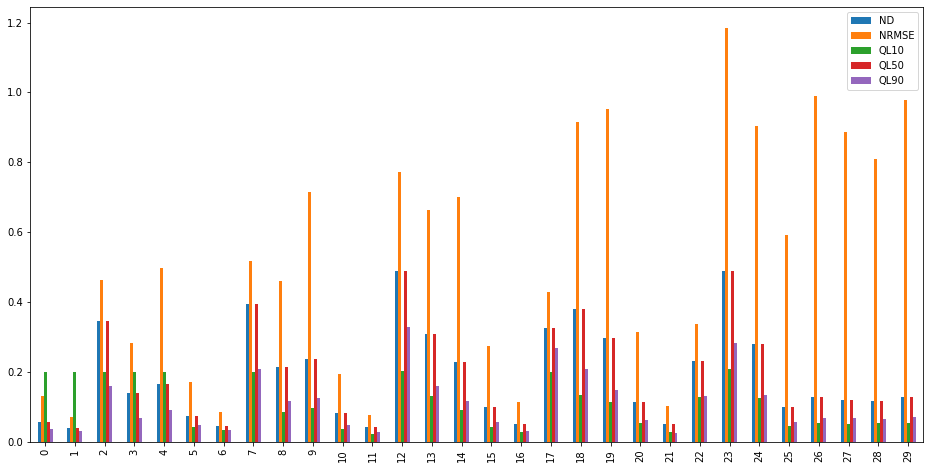

In [136]:
import matplotlib.pyplot as plt
pd.read_csv('./save/test_metrics.csv').plot(kind='bar', figsize=(16, 8))
plt.savefig('./save/test_metrics.pdf', format='pdf')

In [62]:
Y_hat_1[series[key][0]:series[key][1],:].shape

(36, 5256)

In [34]:
pickle.load(open(os.path.join('./data', 'scaler_electricity_24.pkl'), 'rb'))[1].mean_.shape #.inverse_transform(x)

(168,)

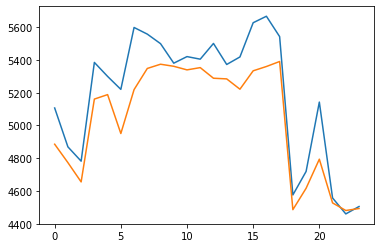

In [5]:
import matplotlib.pyplot as plt
import numpy as np
x = np.load('./save/power_3_true.npy')
x = x.reshape(183, int(x.shape[0]/183)*3)
x.shape
plt.plot(x[0,:24])

x = np.load('./save/power_3_q_50.npy')
x = x.reshape(183, int(x.shape[0]/183)*3)
x.shape
plt.plot(x[0,:])

In [6]:
x.shape

(183, 4008)

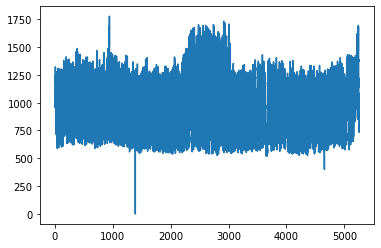

In [9]:
import matplotlib.pyplot as plt
import numpy as np
x = np.load('./save/elect_3_true.npy')
x = x.reshape(321, int(x.shape[0]/321)*3)
x.shape
plt.plot(x[0,:])

# x = np.load('./save/elect_3_q_50.npy')
# x = x.reshape(321, int(x.shape[0]/321)*3)
# x.shape
# plt.plot(x[0,:])

In [109]:
x[:,-3816:].shape

(183, 3816)

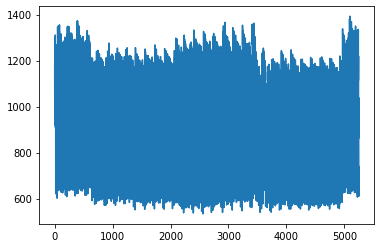

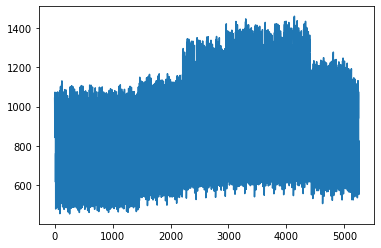

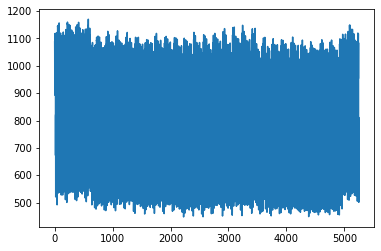

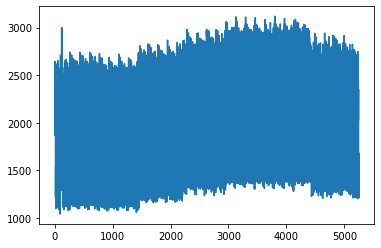

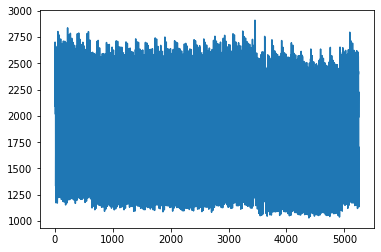

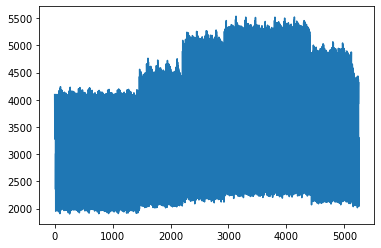

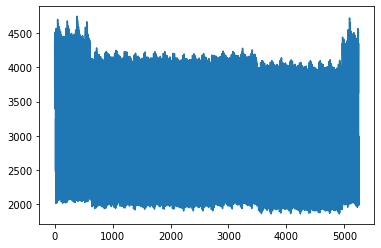

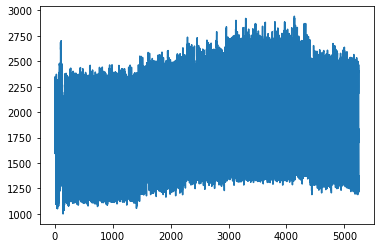

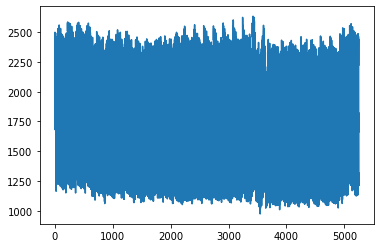

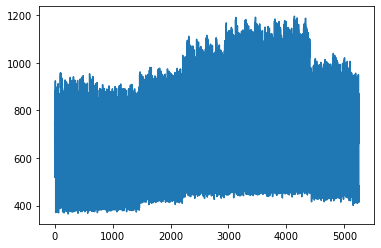

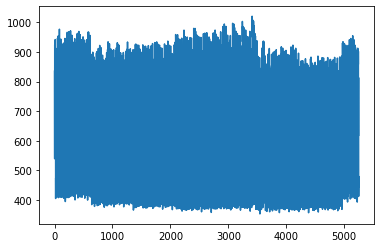

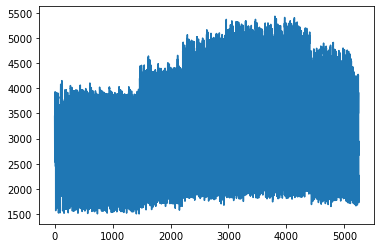

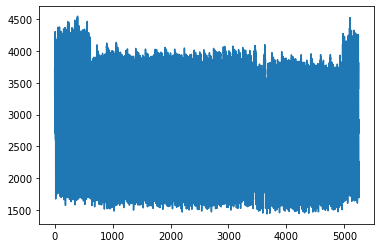

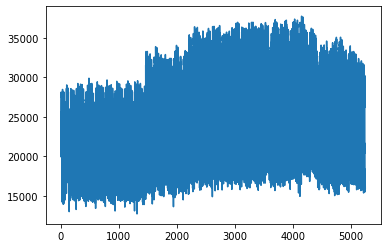

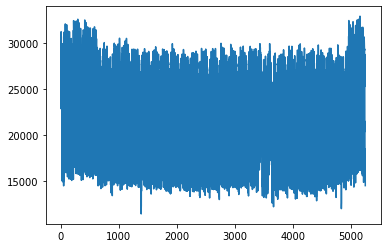

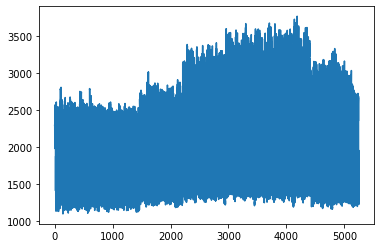

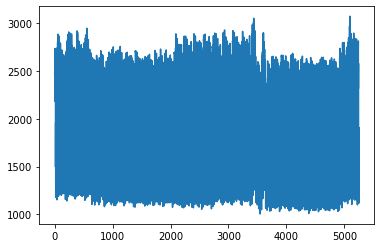

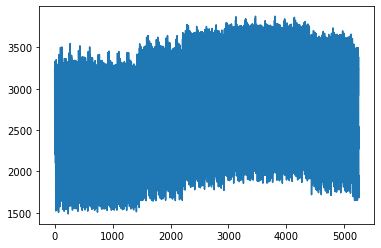

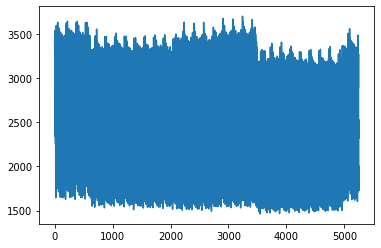

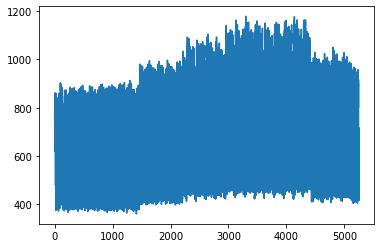

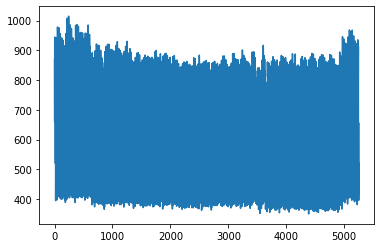

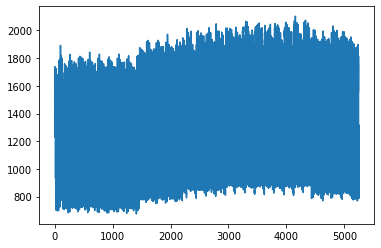

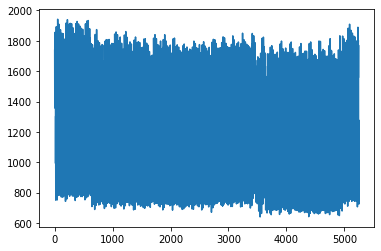

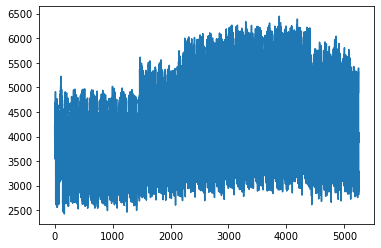

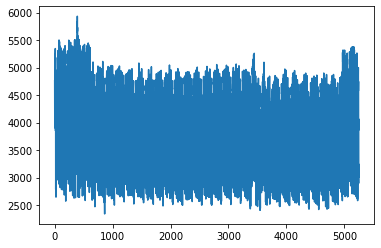

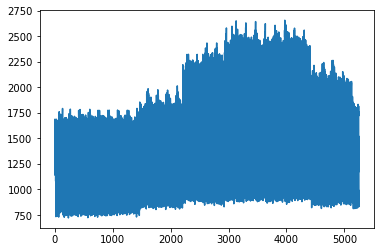

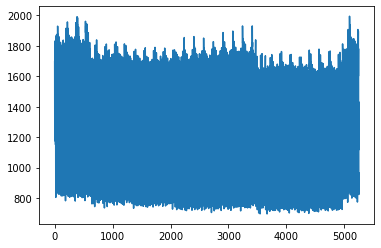

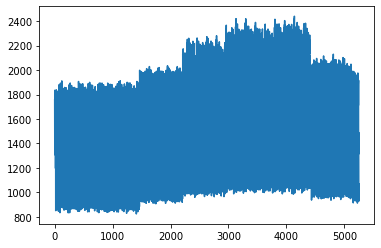

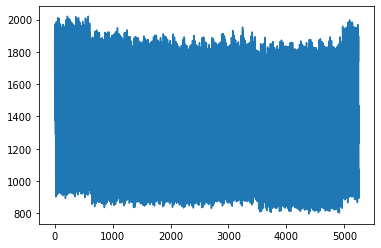

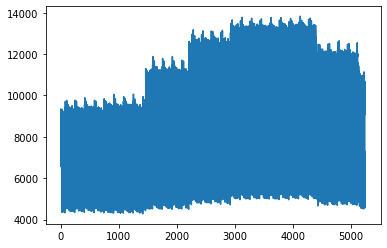

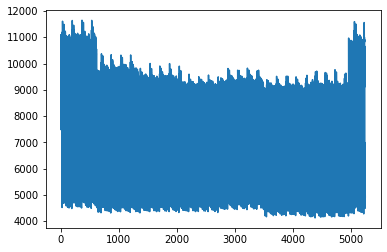

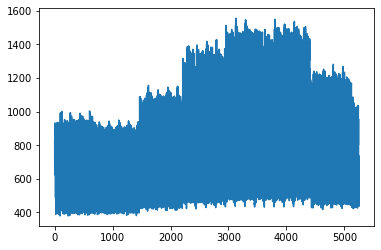

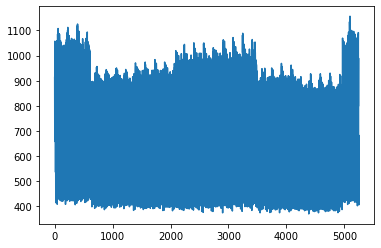

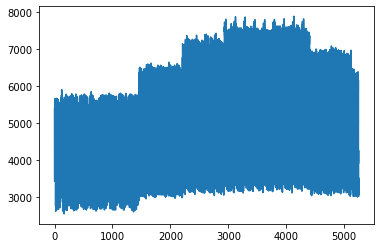

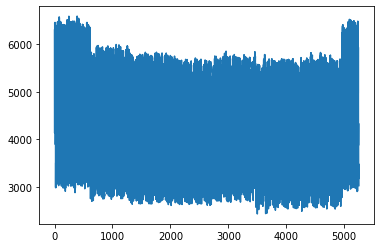

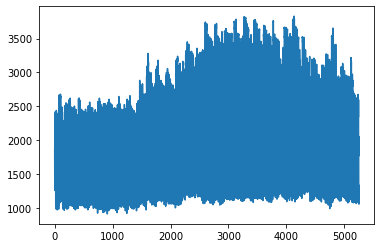

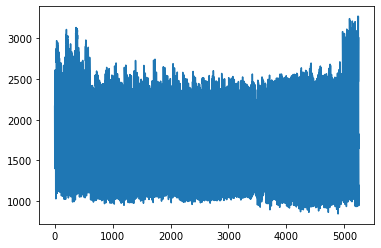

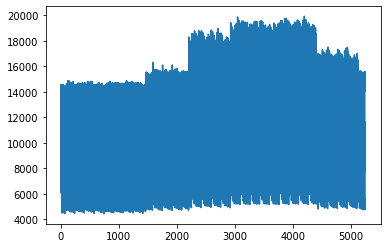

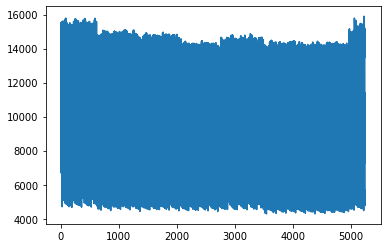

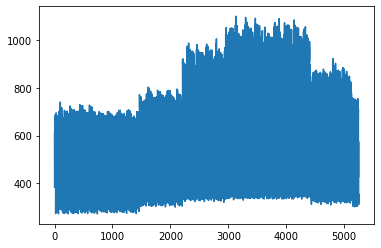

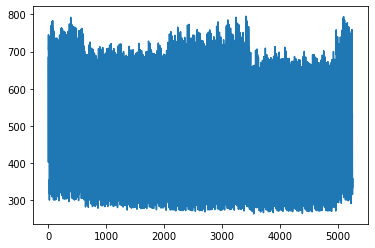

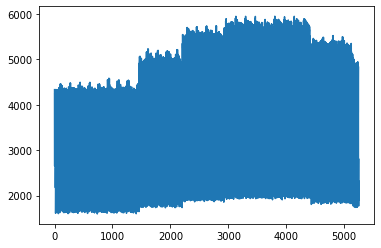

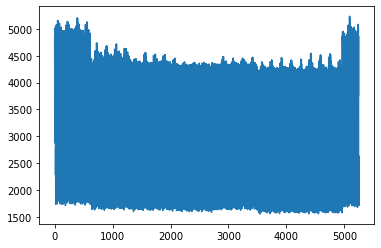

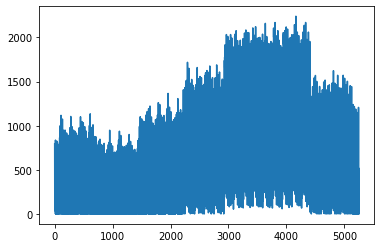

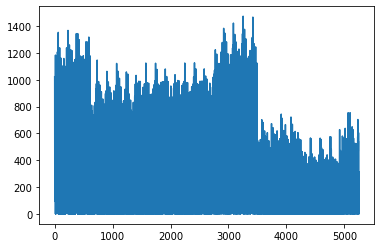

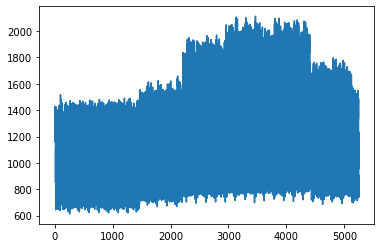

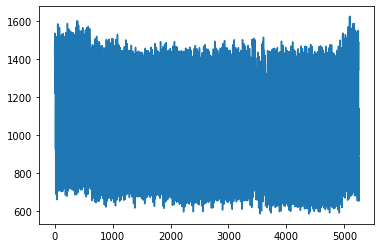

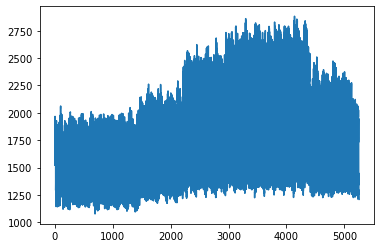

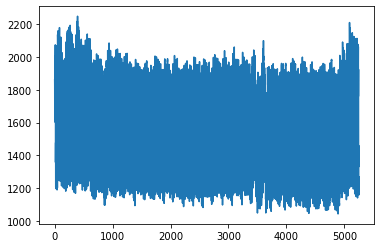

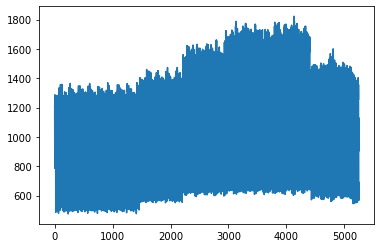

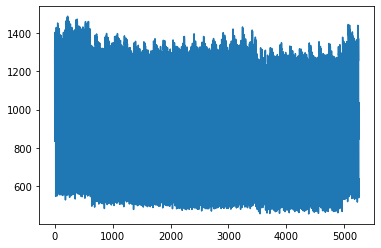

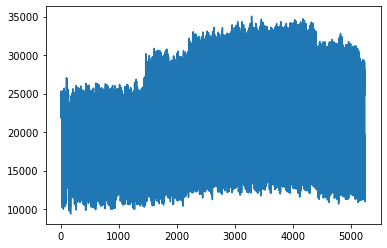

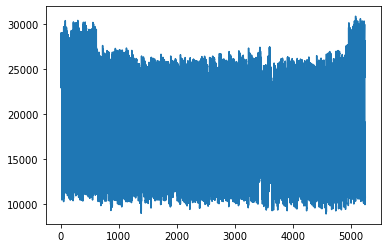

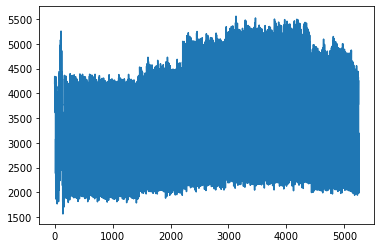

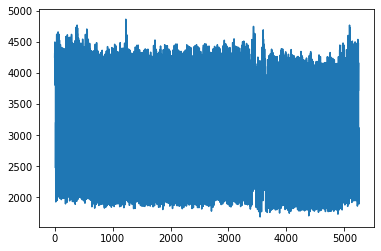

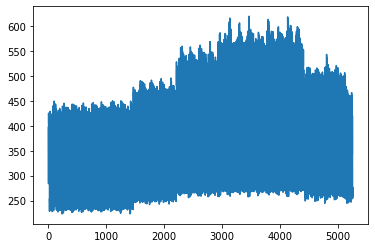

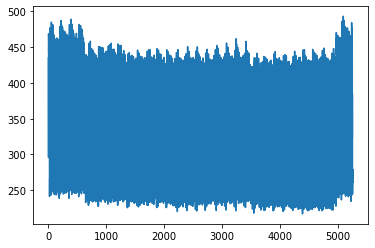

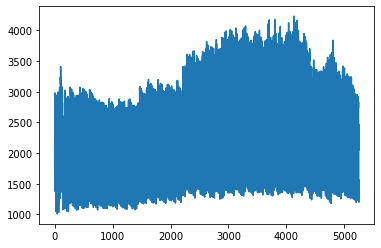

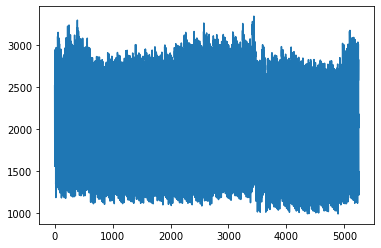

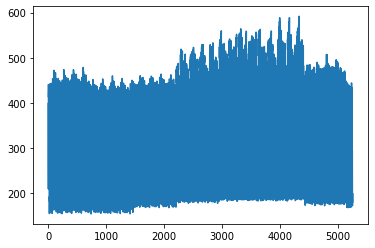

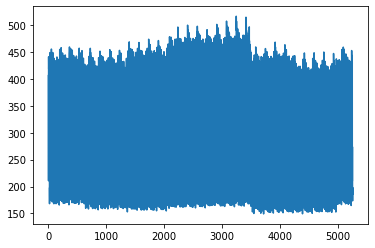

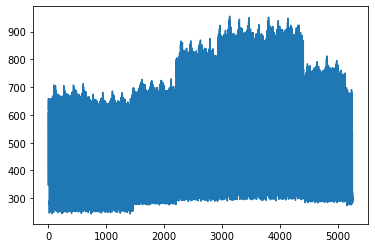

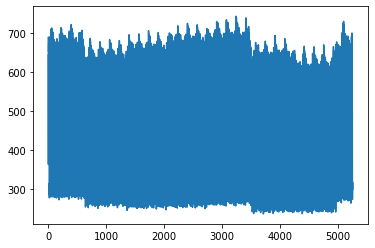

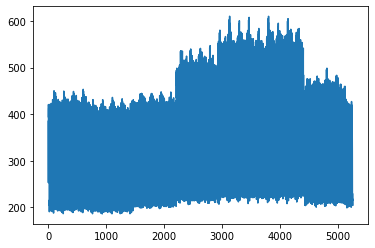

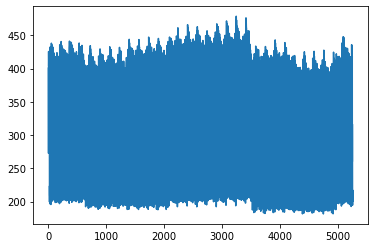

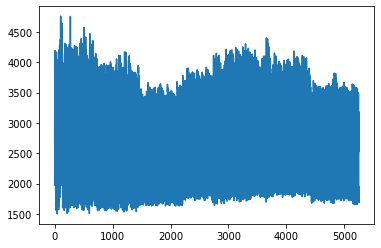

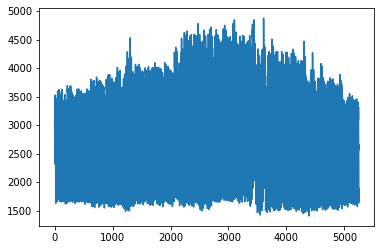

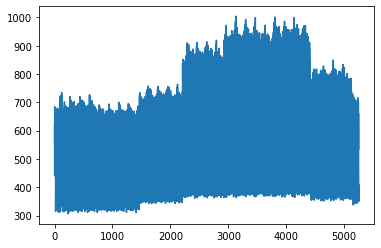

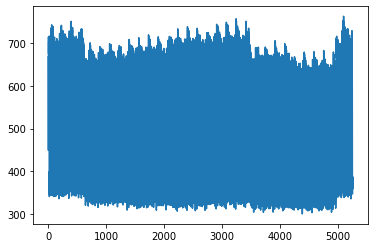

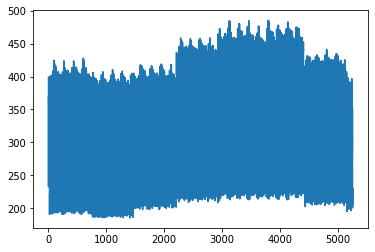

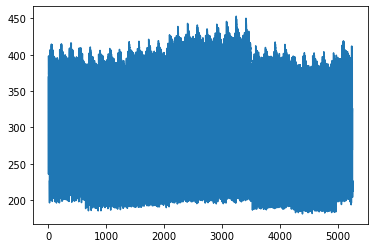

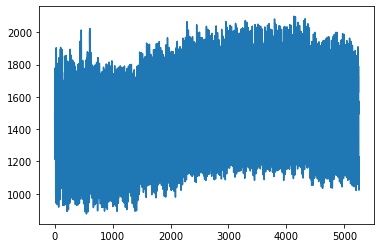

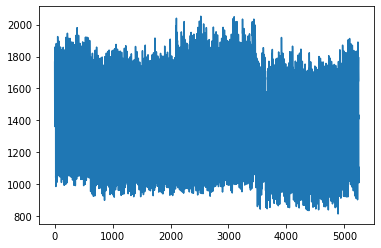

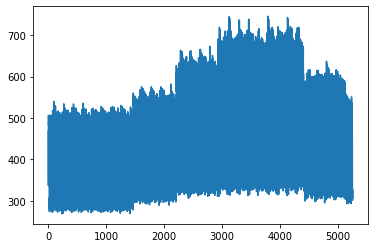

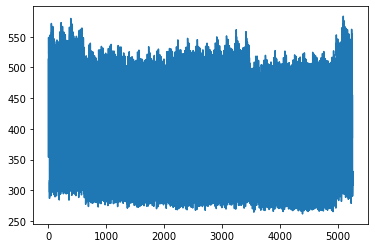

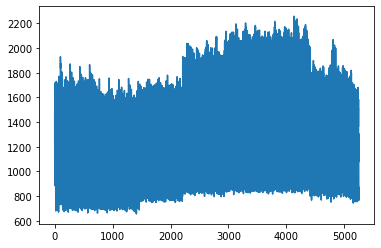

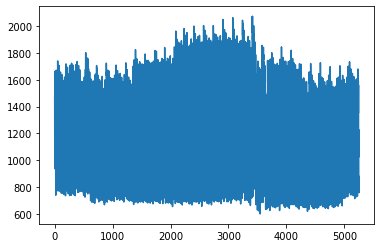

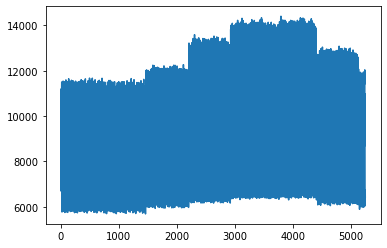

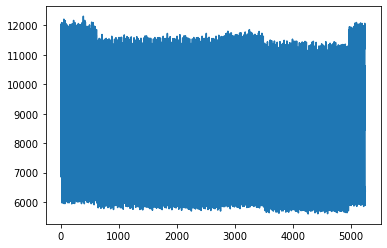

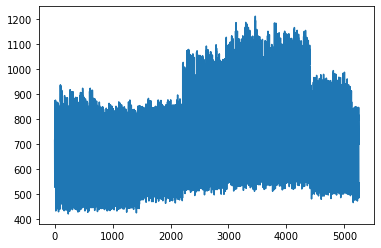

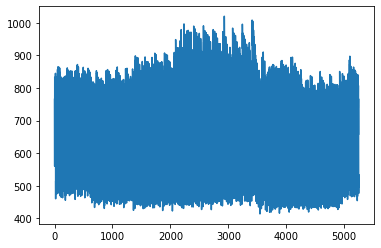

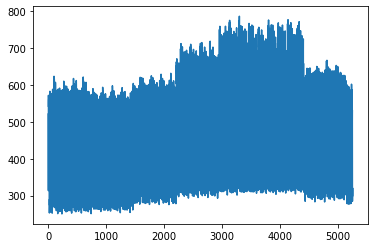

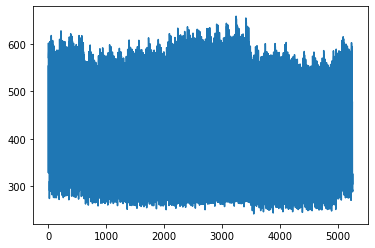

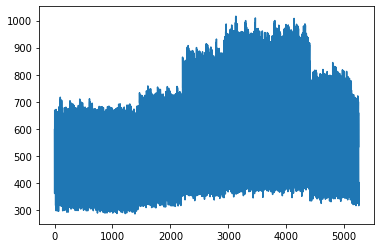

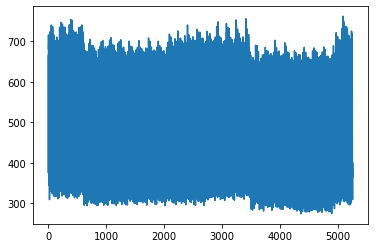

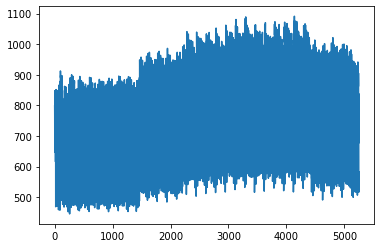

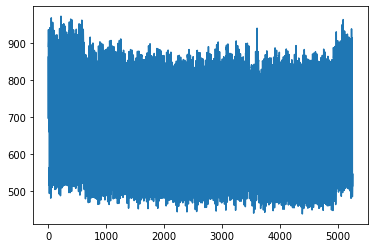

KeyboardInterrupt: 

In [131]:
for i in range(x.shape[0]):
    plt.plot(x[i,:])
    plt.show()

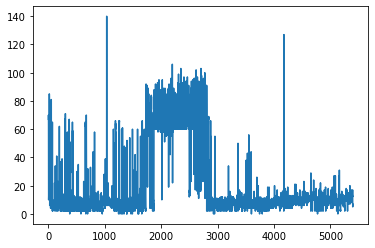

In [11]:
import matplotlib.pyplot as plt
import numpy as np
x = np.load('./save/elect_36_true.npy')
x = x.reshape(321, int(x.shape[0]/321)*36)    ########################## 5256
x = np.fliplr(x)
#x[90:183,:]
plt.plot(x[0,:])

In [112]:
x[:,-5256:].shape

(321, 5256)

In [113]:
print(np.delete(x[:,-5256:], 182, 0).shape)

(320, 5256)


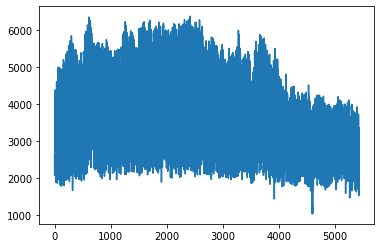

In [103]:
C = np.delete(x, 182, 0)
C.shape
plt.plot(C[181,:])


In [85]:
x.shape

(321, 5424)

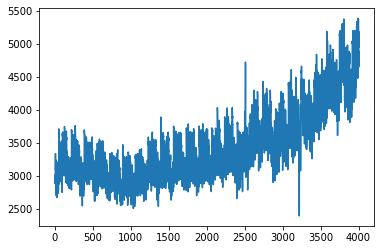

In [132]:
import matplotlib.pyplot as plt
import numpy as np
x = np.load('./save/power_3_q_50.npy')
x = x.reshape(183, int(x.shape[0]/183)*3)
x = np.fliplr(x)
#x[90:183,:]
plt.plot(x[0,:])

In [134]:
x.shape

(183, 4008)

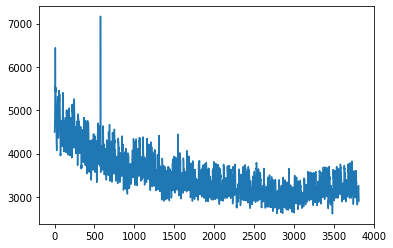

In [26]:
import matplotlib.pyplot as plt
import numpy as np
x = np.load('./save/power_36_true.npy')
x = x.reshape(183, int(x.shape[0]/183)*36)
x.shape
#x[90:183,:]
plt.plot(x[0,-3816:])

In [18]:
x[:, -3816:].shape

(183, 3816)

In [15]:
x.shape

(183, 3816)

In [8]:
x = np.load('./save/power_36_true.npy')
x.reshape(321, 1752*3)
x.shape

ValueError: cannot reshape array of size 698328 into shape (321,5256)

In [69]:
0.15023474178403756*25560

3840.0

In [64]:
x = np.load('./save/power_24_q_50.npy').shape
x

(29189, 24)

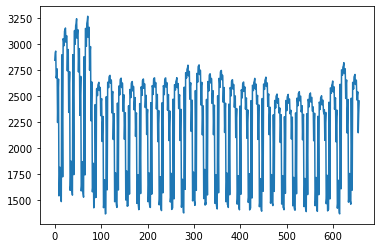

In [71]:
import matplotlib.pyplot as plt
plt.plot(x[180,:])

[StandardScaler(copy=True, with_mean=True, with_std=True),
 StandardScaler(copy=True, with_mean=True, with_std=True)]

In [35]:
!python3 ec_feature_preprocess.py --data-folder='data' \
                                  --file-name='europe_power_system.csv' \
                                  --pickle-name='europe_power_system_24.pkl' \
                                  --horizon=24 \

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180


In [72]:
df = pd.read_csv(os.path.join('data', 'europe_power_system.csv'), sep=",", index_col=0, parse_dates=True, decimal='.')
df = df.reset_index()
df = df.drop([df.columns[0]], axis=1).transpose()#
dt = df.rename(columns=df.iloc[0]).values #.drop(df.index[0])
dt

utc_timestamp


array([[4138.83, 4038.69, 3955.79, ..., 5106.65, 4869.27, 4781.93],
       [2370.48, 2307.45, 2272.86, ..., 3789.92, 3637.43, 3568.99],
       [4659.4 , 4552.1 , 4469.26, ..., 5632.9 , 5212.93, 4926.45],
       ...,
       [   0.  ,    0.  ,    0.  , ...,    0.  ,    0.  ,    0.  ],
       [   0.  ,    0.  ,    0.  , ...,    0.  ,    0.  ,    0.  ],
       [   0.  ,    0.  ,    0.  , ...,    0.  ,    0.  ,    0.  ]])

In [73]:
dt.shape

(183, 25560)

In [50]:
dt.shape

(319, 26305)

In [15]:
import os
import _pickle as pickle

with open(os.path.join('data', 'power_system_122.pkl'), 'rb') as f:
    [trainX_dt,trainX2_dt, trainY_dt,trainY2_dt, testX_dt, testX2_dt, testY_dt, testY2_dt] = pickle.load(f)

In [16]:
testY_dt.shape

(38796, 36)

In [17]:
split = int(0.5*testY_dt.shape[0])
split

19398

In [18]:
testY_dt#[:split,:].shape

array([[5.11893994e+03, 5.11645996e+03, 5.23977979e+03, ...,
        5.10664990e+03, 4.86927002e+03, 4.78193018e+03],
       [4.34745020e+03, 4.31037988e+03, 4.26268018e+03, ...,
        5.24141016e+03, 5.16368994e+03, 5.12185986e+03],
       [4.44570020e+03, 4.49175977e+03, 4.52212012e+03, ...,
        4.73102002e+03, 4.59327002e+03, 4.47335010e+03],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        8.00000000e+00, 1.10000000e+01, 1.20000000e+01],
       [1.70000000e+01, 8.00000000e+00, 2.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.10000000e+01, 1.70000000e+01, 1.80000000e+01]])

In [54]:
## The date range
date_list = pd.date_range(start='2017-01-16 00:00:00', end='2017-11-30 23:00:00')
date_list = pd.to_datetime(date_list)

In [55]:
len(date_list)

319

In [56]:
testY_dt[split:,:].shape

(29189, 24)

In [57]:
int(0.5*testY_dt.shape[0])

29188

In [58]:
testY2_dt[:split, :, :].shape

(29188, 24, 8)

In [60]:
df = pd.read_csv('./data/europe_power_system.csv')
df

,utc_timestamp,NO_2_load_actual_entsoe_transparency,NO_3_load_actual_entsoe_transparency,NO_1_load_actual_entsoe_transparency,NO_4_load_actual_entsoe_transparency,NO_5_load_actual_entsoe_transparency,GR_load_actual_entsoe_power_statistics,SE_4_load_actual_entsoe_transparency,SE_3_load_actual_entsoe_transparency,SE_1_load_actual_entsoe_transparency,...,SI_solar_generation_actual,BE_solar_generation_actual,SE_solar_generation_actual,CZ_solar_generation_actual,FR_solar_generation_actual,GB_GBN_solar_generation_actual,PT_solar_generation_actual,DE_transnetbw_solar_generation_actual,DK_1_solar_generation_actual,DK_2_solar_generation_actual
0,2015-01-01 00:00:00,4138.83,2370.48,4659.40,2090.94,2211.13,5537.0,2267.0,9520.0,1120.0,...,0.00,0.00,0.0102,0.0,-1.0,0.0,0.0,0.0,0.0,0.0
1,2015-01-01 01:00:00,4038.69,2307.45,4552.10,2078.44,2128.31,5227.0,2281.0,9277.0,1092.0,...,0.00,0.00,0.0090,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2015-01-01 02:00:00,3955.79,2272.86,4469.26,2037.06,2147.59,4977.0,2313.0,9132.0,1059.0,...,0.00,0.00,0.0071,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2015-01-01 03:00:00,3900.05,2285.79,4442.35,2012.77,2114.13,4876.0,2372.0,9083.0,1019.0,...,0.00,0.00,0.0124,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2015-01-01 04:00:00,3914.78,2333.07,4487.52,2036.84,2130.82,4906.0,2424.0,9102.0,990.0,...,0.00,0.00,0.0134,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2015-01-01 05:00:00,3971.86,2338.56,4646.16,2036.36,2137.80,4951.0,2395.0,9353.0,1045.0,...,0.00,0.00,0.0090,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,2015-01-01 06:00:00,4024.11,2353.71,4788.48,2116.42,2131.80,5147.0,2489.0,9567.0,1066.0,...,0.00,0.00,0.0178,3.9,0.0,0.0,0.0,0.0,0.0,0.0
7,2015-01-01 07:00:00,4096.00,2323.94,4839.80,2148.27,2159.08,5723.0,2593.0,9629.0,1033.0,...,1.33,0.04,0.0239,7.3,2.0,0.0,0.3,5.0,0.0,0.0
8,2015-01-01 08:00:00,4182.63,2350.64,4929.96,2156.60,2232.49,6417.0,2541.0,9733.0,1010.0,...,4.97,92.66,0.0429,21.0,234.0,23.0,50.9,60.0,1.0,1.0
9,2015-01-01 09:00:00,4278.25,2321.85,5049.85,2138.52,2252.97,7050.0,2561.0,10024.0,1192.0,...,8.23,374.89,0.0716,36.6,996.0,102.0,177.0,113.0,2.0,4.0


In [38]:
!python3 ec_feature_preprocess.py --data-folder='data' \
                                  --file-name='europe_power_system.csv' \
                                  --pickle-name='power_system_122.pkl' \
                                  --horizon=3

Station 0
Station 1
^C
Traceback (most recent call last):
  File "ec_feature_preprocess.py", line 118, in <module>
    nYear_X, nYear_Y = time_index_x.year-yr, time_index_y.year-yr
  File "/appl/soft/ai/miniconda3/envs/python-data-3.7.3-1/lib/python3.7/site-packages/pandas/core/accessor.py", line 77, in _getter
    return self._delegate_property_get(name)
  File "/appl/soft/ai/miniconda3/envs/python-data-3.7.3-1/lib/python3.7/site-packages/pandas/core/indexes/datetimelike.py", line 714, in _delegate_property_get
    result = Index(result, name=self.name)
  File "/appl/soft/ai/miniconda3/envs/python-data-3.7.3-1/lib/python3.7/site-packages/pandas/core/indexes/base.py", line 330, in __new__
    elif is_extension_array_dtype(data) or is_extension_array_dtype(dtype):
  File "/appl/soft/ai/miniconda3/envs/python-data-3.7.3-1/lib/python3.7/site-packages/pandas/core/dtypes/common.py", line 1749, in is_extension_array_dtype
    registry.find(dtype) is not None)
  File "/appl/soft/ai/miniconda3

In [29]:
import datetime
datetime.datetime.today()
datetime.datetime(2020, 1, 4, 23, 24, 55, 173504).weekday()
#datetime.datetime.today().weekday()

5

In [2]:
dir_path = '/home/chenyitian/TCNPaperExperiments/EC/data'
dt = np.loadtxt(os.path.join(dir_path,"modelData.csv"), dtype=np.str, delimiter=",")

In [3]:
## The date range
date_list = pd.date_range(start='01/01/2012', end='31/12/2014')
date_list = pd.to_datetime(date_list)

hour_list = []
for nDate in date_list:
    for nHour in range(24):
        tmp_timestamp = nDate+timedelta(hours=nHour)
        hour_list.append(tmp_timestamp)
hour_list = np.array(hour_list)

In [4]:
station_index = list(range(370))

sliding_window_dis = 24;
sample_len = 192; #168+24
input_len = 168;
output_len = 24;
total_n = 800; ## The total days
test_n = 7     ## The testing days, day of the last 7 days
train_n = total_n - test_n ## The training days

In [5]:
trainX_list = [];trainX2_list = [];trainY_list = [];trainY2_list = []
testX_list = [];testX2_list = [];testY_list = [];testY2_list = []
#for station in station_index:
for station in station_index:
    print(station)
    sub_series = dt[station,1:].astype('float32')
    sub_index = np.array(range(26304))-np.min(np.where(sub_series>0))
    trainX = np.zeros(shape=(train_n, input_len))       ## The input series
    trainY = np.zeros(shape=(train_n, output_len))      ## The output series  

    testX  = np.zeros(shape=(7, input_len))        ## The input series
    testY = np.zeros(shape=(7, output_len))        ## The output series

    covariate_num = 8   # other features covariate_num: sub_index, station_id,nYear,nMonth,day_of_month, day_of_week, iHour
    trainX2 = np.zeros(shape=(train_n, input_len,covariate_num))
    trainY2 = np.zeros(shape=(train_n, output_len,covariate_num))
    testX2 = np.zeros(shape=(7, input_len,covariate_num))
    testY2 = np.zeros(shape=(7, output_len,covariate_num))
    ### Testing samples (7+1)*24
    ts_len = sub_series.shape[0]
    start_index = ts_len-sample_len
    for i in range(total_n):
        ### The sequence data
        series_x = sub_series[start_index:start_index+input_len]
        series_y = sub_series[start_index+input_len:start_index+sample_len]
        ### The index data
        hour_mean = np.mean(series_x.reshape(-1,24),axis=0)
        index_x = np.tile(hour_mean,7)
        index_y = np.tile(hour_mean,1)
        ### The covariate
        station_X = np.repeat(station, input_len)
        station_Y = np.repeat(station, output_len)
        ### the time index
        time_index_x = pd.to_datetime(hour_list[start_index:start_index+input_len])
        time_index_y = pd.to_datetime(hour_list[start_index+input_len:start_index+sample_len])
        nYear_X, nYear_Y = time_index_x.year-2012, time_index_y.year-2012
        nMonth_X, nMonth_Y = time_index_x.month-1, time_index_y.month-1
        mDay_X, mDay_Y = time_index_x.day-1, time_index_y.day-1
        wDay_X, wDay_Y = time_index_x.weekday, time_index_y.weekday
        nHour_X, nHour_Y = time_index_x.hour, time_index_y.hour
        holiday_X,holiday_Y = (mDay_X==24),(mDay_Y==24)
    
        covariate_X = np.c_[station_X,index_x,nYear_X,nMonth_X,mDay_X,wDay_X,nHour_X,holiday_X]
        covariate_Y = np.c_[station_Y,index_y,nYear_Y,nMonth_Y,mDay_Y,wDay_Y,nHour_Y,holiday_Y]
    
        if(i<test_n):
            test_index = i
            testX[test_index] = series_x
            testY[test_index] = series_y
            testX2[test_index] = covariate_X
            testY2[test_index] = covariate_Y
        
        else:
            trainX[i-test_n] = series_x
            trainY[i-test_n] = series_y
            trainX2[i-test_n] = covariate_X
            trainY2[i-test_n] = covariate_Y
        # update the start_index
        start_index = start_index - sliding_window_dis
  

    testX_list.append(testX)
    testX2_list.append(testX2)
    testY_list.append(testY)
    testY2_list.append(testY2)
    
    trainX_list.append(trainX)
    trainX2_list.append(trainX2)
    trainY_list.append(trainY)
    trainY2_list.append(trainY2)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [6]:
testX_dt = np.vstack(testX_list)
testY_dt = np.vstack(testY_list)
testX2_dt = np.vstack(testX2_list)
testY2_dt = np.vstack(testY2_list)

trainX_dt = np.vstack(trainX_list)
trainY_dt = np.vstack(trainY_list)
trainX2_dt = np.vstack(trainX2_list)
trainY2_dt = np.vstack(trainY2_list)

In [7]:
testY_dt.shape
### Save the data
#with open('tensor_feature.pkl', 'wb') as f:
#    pickle.dump([trainX_dt,trainX2_dt, trainY_dt,trainY2_dt, testX_dt, testX2_dt,testY_dt,testY2_dt], f, -1)
#with open('tensor_feature.pkl', 'rb') as f:
#    [trainX_dt,trainX2_dt, trainY_dt,trainY2_dt, testX_dt, testX2_dt,testY_dt,testY2_dt] = pickle.load(f)

(2590, 24)

In [8]:
scaler = preprocessing.StandardScaler()
scaler.fit(trainX_dt)

trainX_dt = scaler.transform(trainX_dt)
testX_dt = scaler.transform(testX_dt)
scaler2 = preprocessing.StandardScaler()
scaler2.fit(trainX2[:,:,1])
trainX2[:,:,1] = scaler2.transform(trainX2[:,:,1])
testX2[:,:,1] = scaler2.transform(testX2[:,:,1])

### The filter data
### Select the data of the Nov
# isNov = trainX2_dt[:,:,3]>=11
# trainX_dt = trainX_dt[isNov[:,0]]
# trainY_dt = trainY_dt[isNov[:,0]]
# trainX2_dt = trainX2_dt[isNov[:,0]]
# trainY2_dt = trainY2_dt[isNov[:,0]]
### Save the data
with open('feature_prepare.pkl', 'wb') as f:
    pickle.dump([trainX_dt,trainX2_dt, trainY_dt,trainY2_dt, testX_dt, testX2_dt,testY_dt,testY2_dt], f, -1)